# Interactive EV Charging Load Simulation and ML Prediction in Colab

This notebook loads data, trains an ML model, and then enters an
interactive loop prompting the user for simulation parameters to generate
predictions and visualizations.


In [17]:
# ####################################
# Cell 1: Setup, Mount Drive, Imports
# ####################################
print("--- Setup & Imports ---")

# Mount Google Drive
from google.colab import drive
import sys
import os # Import os here

try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
    # ** IMPORTANT: Adjust this path if your file is in a subfolder **
    DRIVE_FOLDER_PATH = '/content/drive/MyDrive/'
    if not os.path.exists(DRIVE_FOLDER_PATH):
         print(f"ERROR: Mounted drive but cannot access path: {DRIVE_FOLDER_PATH}")
         print("Please check the DRIVE_FOLDER_PATH variable.")
         # sys.exit("Stopping execution.") # Uncomment to stop if path fails
    else:
        print(f"Using Google Drive path: {DRIVE_FOLDER_PATH}")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Please ensure you have authorized access.")
    DRIVE_FOLDER_PATH = './' # Fallback to local Colab storage if mount fails (won't find files)
    # sys.exit("Stopping execution due to Drive mounting failure.") # Uncomment to stop

# Install necessary packages (less likely needed now, but safe)
# !pip install pandas numpy scikit-learn joblib openpyxl matplotlib seaborn

# Basic Imports
import pandas as pd
import numpy as np
import time
import random
import traceback # For error printing

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# Set default style for plots
plt.style.use('seaborn-v0_8-darkgrid') # Use a visually appealing style

# --- Configuration ---
EV_EXCEL_FILENAME = 'EVs_cases_1800 EVs for 33 bus MV distribution network.xlsx'
TRAINING_CSV_FILENAME = 'training_data.csv' # Assumed to be uploaded

EV_DATA_FILE_PATH = os.path.join(DRIVE_FOLDER_PATH, EV_EXCEL_FILENAME)
TRAINING_DATA_PATH = os.path.join(DRIVE_FOLDER_PATH, TRAINING_CSV_FILENAME)

# ML Model Configuration
FEATURE_COLUMNS = [
    'evPercentage', 'chargingLogicCode', 'chargeDelay', 'peakStart', 'peakEnd',
    'peakReduction', 'socTarget', 'globalChargeLimit', 'scheduleShift',
    'socAdjustment', 'chargingEfficiency'
]
TARGET_COLUMNS = [f'Load_{h}' for h in range(24)]
# Numeric mapping for user input
LOGIC_MAP_INTERACTIVE = {1: 'immediate', 2: 'delayed', 3: 'offpeak', 4: 'soc_target'}
LOGIC_MAP_REVERSE = {v: k for k, v in LOGIC_MAP_INTERACTIVE.items()} # For ML input prep
RANDOM_STATE = 42
TEST_SIZE = 0.2

print("Setup complete. Necessary libraries imported.")
print(f"Expecting Excel file at: {EV_DATA_FILE_PATH}")
print(f"Expecting Training CSV at: {TRAINING_DATA_PATH}")

--- Setup & Imports ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Using Google Drive path: /content/drive/MyDrive/
Setup complete. Necessary libraries imported.
Expecting Excel file at: /content/drive/MyDrive/EVs_cases_1800 EVs for 33 bus MV distribution network.xlsx
Expecting Training CSV at: /content/drive/MyDrive/training_data.csv


In [18]:
# ####################################
# Cell 2: Define Core Simulation Functions
# ####################################
print("\n--- Defining Core Simulation Functions ---")

# --- Paste the load_and_preprocess_data function (same as before) ---
def load_and_preprocess_data(filepath="EVs_cases_1800_EVs_for_33_Bus_MV_distribution_network.xlsx", sheet_name='V2G'):
    """Loads and preprocesses the EV data from the Excel file (robust version)."""
    print(f"Attempting to load data from: {filepath}")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found: {filepath}. Please check the path and ensure Google Drive is mounted.")
    try:
        start_time = time.time()
        df = pd.read_excel(filepath, sheet_name=sheet_name, header=None, skiprows=3)
    except Exception as e: raise ValueError(f"Error reading Excel file: {e}")
    if df.empty: raise ValueError("Loaded DataFrame is empty after skipping rows.")
    num_cols = df.shape[1]
    if num_cols < 31: raise ValueError(f"Expected at least 31 columns, found {num_cols}")
    col_names=['row_num_excel','VehicleType','ChEff_pct','DchEff_pct','FeatureName','EmptyColF','FeatureIndexG']
    hour_cols_raw=[f'H{i}' for i in range(1, 25)]
    col_names.extend(hour_cols_raw)
    df.columns=col_names[:num_cols]
    if 'EmptyColF' in df.columns: df.drop(columns=['EmptyColF'], inplace=True)
    if 'FeatureName' in df.columns: df['FeatureName'] = df['FeatureName'].astype(str).str.strip()
    else: raise ValueError("'FeatureName' column not found.")
    rows_per_ev=16; df['EV_ID'] = df.index // rows_per_ev
    static_df = df.groupby('EV_ID').first()[['VehicleType', 'ChEff_pct', 'DchEff_pct']].copy()
    static_df['ChargeEfficiency'] = pd.to_numeric(static_df['ChEff_pct'], errors='coerce') / 100.0
    static_df['DischargeEfficiency'] = pd.to_numeric(static_df['DchEff_pct'], errors='coerce') / 100.0
    static_df.drop(columns=['ChEff_pct', 'DchEff_pct'], inplace=True)
    static_df['VehicleType'] = pd.to_numeric(static_df['VehicleType'], errors='coerce')
    static_like_feature_names=['Capacity','Max Charge','Max Discharge','Minimun Charge','Previous State','Bus']
    static_like_data = df[df['FeatureName'].isin(static_like_feature_names)].copy()
    if 'Minimun Charge' not in static_like_data['FeatureName'].unique(): print("Warning: 'Minimun Charge' (typo) not found.")
    try: h1_col_index = df.columns.get_loc('H1')
    except KeyError: raise ValueError("Column 'H1' not found after potential drops.")
    static_like_data['Value'] = pd.to_numeric(static_like_data.iloc[:, h1_col_index], errors='coerce')
    static_pivoted = static_like_data.pivot_table(index='EV_ID', columns='FeatureName', values='Value')
    static_rename_map = {'Capacity':'CapacityMWh','Max Charge':'MaxChargeRateMW','Max Discharge':'MaxDischargeRateMW',
                         'Minimun Charge':'MinChargeLimitMWh','Previous State':'PreviousStateMWh','Bus':'Bus'}
    rename_map_existing = {k: v for k, v in static_rename_map.items() if k in static_pivoted.columns}
    static_pivoted.rename(columns=rename_map_existing, inplace=True)
    if 'Bus' in static_pivoted.columns: static_pivoted['Bus']=pd.to_numeric(static_pivoted['Bus'],errors='coerce').round().astype('Int64')
    try:
        hour_col_indices = [df.columns.get_loc(f'H{i}') for i in range(1, 25)]
        hour_cols_actual = df.columns[hour_col_indices].tolist()
    except KeyError as e: raise ValueError(f"Could not find hour columns (H1-H24): {e}")
    connect_data_long = df[df['FeatureName']=='Connect (1/0)'][['EV_ID'] + hour_cols_actual].copy()
    connect_cols_list = [f'Connect_{h}' for h in range(24)] # Define standard names
    if connect_data_long.empty:
        print("Warning: No 'Connect (1/0)' data. Creating placeholders.")
        connect_data = pd.DataFrame(index=static_df.index); connect_data[connect_cols_list] = 0
    else:
        connect_data=connect_data_long.set_index('EV_ID')
        connect_rename_map={hour_cols_actual[i]: connect_cols_list[i] for i in range(24)}
        connect_data.rename(columns=connect_rename_map, inplace=True)
        for col in connect_data.columns: connect_data[col]=pd.to_numeric(connect_data[col],errors='coerce').fillna(0).astype(int)
    final_df=static_df.join(static_pivoted,on='EV_ID',how='left').join(connect_data,on='EV_ID',how='left')
    final_df['CapacityMWh']=pd.to_numeric(final_df.get('CapacityMWh'),errors='coerce')
    final_df['PreviousStateMWh']=pd.to_numeric(final_df.get('PreviousStateMWh'),errors='coerce')
    final_df['InitialSOC_pct']=0.0
    valid_capacity_mask=(final_df['CapacityMWh'] > 1e-6) & (final_df['CapacityMWh'].notna())
    if 'CapacityMWh' in final_df.columns: # Ensure column exists
        final_df.loc[valid_capacity_mask,'InitialSOC_pct']=(final_df.loc[valid_capacity_mask,'PreviousStateMWh'].fillna(0) / final_df.loc[valid_capacity_mask,'CapacityMWh']) * 100
    final_df['InitialSOC_pct']=final_df['InitialSOC_pct'].clip(0,100).fillna(0)
    final_df['MaxChargeRateMW']=pd.to_numeric(final_df.get('MaxChargeRateMW'),errors='coerce').fillna(0)
    if 'MinChargeLimitMWh' not in final_df.columns: final_df['MinChargeLimitMWh']=np.nan
    final_df['MinChargeLimitMWh']=pd.to_numeric(final_df['MinChargeLimitMWh'],errors='coerce')
    final_df['ChargeEfficiency']=final_df['ChargeEfficiency'].fillna(0.90)
    final_df['DischargeEfficiency']=final_df['DischargeEfficiency'].fillna(0.90)
    initial_rows=len(final_df)
    dropna_cols=[col for col in ['VehicleType','Bus','InitialSOC_pct','CapacityMWh'] if col in final_df.columns]
    final_df=final_df.dropna(subset=dropna_cols)
    if 'CapacityMWh' in final_df.columns and 'MaxChargeRateMW' in final_df.columns:
        final_df=final_df[(final_df['CapacityMWh'] > 1e-6) & (final_df['MaxChargeRateMW'] > 1e-6)]
    rows_dropped=initial_rows-len(final_df)
    if rows_dropped > 0: print(f"Dropped {rows_dropped} rows.")
    if all(col in final_df.columns for col in connect_cols_list):
        connection_times=final_df[connect_cols_list]; any_connection=connection_times.any(axis=1)
        first_connect_col_name=connection_times.idxmax(axis=1); final_df['FirstConnectedHour']=-1
        final_df.loc[any_connection,'FirstConnectedHour']=first_connect_col_name[any_connection].str.extract(r'Connect_(\d+)').astype(int)
    else: print("Warning: Connect columns missing. Setting 'FirstConnectedHour' to -1."); final_df['FirstConnectedHour']=-1
    final_df.reset_index(drop=True, inplace=True)
    required_sim_cols=['EV_ID','VehicleType','ChargeEfficiency','DischargeEfficiency','PreviousStateMWh',
                         'MaxChargeRateMW','MaxDischargeRateMW','CapacityMWh','Bus','MinChargeLimitMWh',
                         'InitialSOC_pct','FirstConnectedHour'] + connect_cols_list
    final_cols_present=[col for col in required_sim_cols if col in final_df.columns]
    final_df_processed=final_df[final_cols_present].copy()
    end_time=time.time()
    print(f"Data loading/preprocessing finished ({end_time - start_time:.2f}s). Shape: {final_df_processed.shape}")
    return final_df_processed


# --- Paste the run_detailed_simulation function (same as before) ---
def run_detailed_simulation(params, base_ev_data):
    """Runs detailed EV charging simulation (robust version)."""
    if base_ev_data is None or base_ev_data.empty: return { 'hourlyLoad': [0.0]*24, 'peakLoad': 0.0, 'totalEnergy': 0.0, 'concurrentEVs': [0]*24, 'finalSOCs': [], 'avgFinalSoc': 0.0, 'busLoads': {}, 'numEVsSimulated': 0 }
    sim_data=base_ev_data.copy()
    n_total_evs=len(sim_data); n_selected_evs=int(round(n_total_evs * params.get('evPercentage', 100.0) / 100.0))
    if n_selected_evs <= 0: return { 'hourlyLoad': [0.0]*24, 'peakLoad': 0.0, 'totalEnergy': 0.0, 'concurrentEVs': [0]*24, 'finalSOCs': [], 'avgFinalSoc': 0.0, 'busLoads': {}, 'numEVsSimulated': 0 }
    if n_selected_evs < n_total_evs: sim_data=sim_data.sample(n=n_selected_evs, random_state=RANDOM_STATE)
    selected_buses_param = params.get('selectedBuses', 'all')
    if selected_buses_param != 'all' and isinstance(selected_buses_param, list):
        try:
            selected_bus_numbers=[int(b) for b in selected_buses_param]
            if 'Bus' in sim_data.columns: sim_data=sim_data[sim_data['Bus'].isin(selected_bus_numbers)]
            else: print("Warning: 'Bus' column missing.")
        except Exception as e: print(f"Warning: Bus filter error: {e}")
    selected_types_param = params.get('selectedEvTypes', [1,2,3])
    if isinstance(selected_types_param, list):
        try:
            selected_types=[int(t) for t in selected_types_param]
            if 'VehicleType' in sim_data.columns:
                available_types=sim_data['VehicleType'].unique()
                if set(selected_types) != set(available_types): sim_data=sim_data[sim_data['VehicleType'].isin(selected_types)]
            else: print("Warning: 'VehicleType' column missing.")
        except Exception as e: print(f"Warning: Type filter error: {e}")
    if sim_data.empty: return { 'hourlyLoad': [0.0]*24, 'peakLoad': 0.0, 'totalEnergy': 0.0, 'concurrentEVs': [0]*24, 'finalSOCs': [], 'avgFinalSoc': 0.0, 'busLoads': {}, 'numEVsSimulated': 0 }
    num_evs_simulated=len(sim_data); ev_states=sim_data.copy()
    if 'InitialSOC_pct' in ev_states.columns: ev_states['CurrentSOC_pct']=(ev_states['InitialSOC_pct'] + params.get('socAdjustment', 0)).clip(0, 100)
    else: ev_states['CurrentSOC_pct'] = 0.0
    if 'CapacityMWh' in ev_states.columns:
        ev_states['CapacityMWh']=pd.to_numeric(ev_states['CapacityMWh'],errors='coerce').fillna(0)
        ev_states['CurrentSOC_MWh']=ev_states['CurrentSOC_pct'] / 100.0 * ev_states['CapacityMWh']
    else: ev_states['CurrentSOC_MWh'] = 0.0
    if 'ChargeEfficiency' not in ev_states.columns: ev_states['ChargeEfficiency'] = 0.9
    ev_states['ChargeEfficiency']=ev_states['ChargeEfficiency'].fillna(0.9)
    charge_logic=params.get('chargingLogic', 'immediate'); charge_delay_hours=params.get('chargeDelay', 0)
    peak_start_hour=params.get('peakStart', 17); peak_end_hour=params.get('peakEnd', 20); peak_reduction_pct=params.get('peakReduction', 50)
    soc_target_pct=params.get('socTarget', 80); global_charge_limit_mw=params.get('globalChargeLimit', 22.0) / 1000.0; schedule_shift=params.get('scheduleShift', 0)
    hourly_load_mw=np.zeros(24); concurrent_evs_count=np.zeros(24, dtype=int)
    bus_ids_in_sim=ev_states['Bus'].dropna().unique() if 'Bus' in ev_states.columns else []
    bus_hourly_loads={int(bus_id): np.zeros(24) for bus_id in bus_ids_in_sim if pd.notna(bus_id)}
    required_loop_cols=['CurrentSOC_MWh','CurrentSOC_pct','CapacityMWh','MaxChargeRateMW','FirstConnectedHour','ChargeEfficiency','Bus'] + [f'Connect_{h}' for h in range(24)]
    missing_loop_cols=[col for col in required_loop_cols if col not in ev_states.columns]
    if missing_loop_cols: print(f"ERROR: Missing essential columns: {missing_loop_cols}."); return { 'hourlyLoad': [0.0]*24, 'peakLoad': 0.0, 'totalEnergy': 0.0, 'concurrentEVs': [0]*24, 'finalSOCs': [], 'avgFinalSoc': 0.0, 'busLoads': {}, 'numEVsSimulated': num_evs_simulated }
    for h in range(24):
        hour_load_mw_iter=0.0; charging_indices_this_hour=[]
        for idx in ev_states.index:
            charge_power_mw=0.0; ev_soc_mwh=ev_states.at[idx,'CurrentSOC_MWh']; ev_soc_pct=ev_states.at[idx,'CurrentSOC_pct']
            ev_capacity_mwh=ev_states.at[idx,'CapacityMWh']; ev_max_charge_mw=ev_states.at[idx,'MaxChargeRateMW']; ev_first_connect=ev_states.at[idx,'FirstConnectedHour']
            ev_efficiency=ev_states.at[idx,'ChargeEfficiency']; ev_bus=ev_states.at[idx,'Bus']
            connect_hour_shifted=(h - schedule_shift + 24) % 24; connect_col=f'Connect_{connect_hour_shifted}'; is_connected=ev_states.at[idx,connect_col]==1
            is_full=ev_soc_pct >= 99.9; can_charge=ev_capacity_mwh > 1e-6 and ev_max_charge_mw > 1e-6 and ev_efficiency > 1e-6
            if is_connected and not is_full and can_charge:
                charge_flag=False
                if charge_logic=='immediate': charge_flag=True
                elif charge_logic=='delayed':
                    if ev_first_connect != -1 and h >= (ev_first_connect + charge_delay_hours): charge_flag=True
                elif charge_logic=='offpeak': charge_flag=True
                elif charge_logic=='soc_target':
                    if ev_soc_pct < soc_target_pct: charge_flag=True
                if charge_flag:
                    max_rate_this_hour_mw=min(ev_max_charge_mw, global_charge_limit_mw)
                    if charge_logic=='offpeak':
                        is_peak_hour=False
                        if peak_start_hour <= peak_end_hour: is_peak_hour = peak_start_hour <= h <= peak_end_hour
                        else: is_peak_hour = h >= peak_start_hour or h <= peak_end_hour
                        if is_peak_hour: max_rate_this_hour_mw *= (1.0 - peak_reduction_pct / 100.0)
                    max_rate_this_hour_mw=max(0.0, max_rate_this_hour_mw)
                    energy_needed_to_full_mwh=ev_capacity_mwh-ev_soc_mwh; max_energy_add_in_hour_mwh=max_rate_this_hour_mw * 1.0 * ev_efficiency
                    desired_energy_add_mwh=max(0.0, min(energy_needed_to_full_mwh, max_energy_add_in_hour_mwh))
                    actual_power_drawn_mw=(desired_energy_add_mwh / ev_efficiency) if desired_energy_add_mwh > 1e-9 else 0.0
                    actual_power_drawn_mw=min(actual_power_drawn_mw, max_rate_this_hour_mw)
                    energy_added_to_battery_mwh=actual_power_drawn_mw * ev_efficiency; new_soc_mwh=min(ev_soc_mwh + energy_added_to_battery_mwh, ev_capacity_mwh)
                    new_soc_pct=(new_soc_mwh / ev_capacity_mwh) * 100.0 if ev_capacity_mwh > 1e-6 else 0
                    ev_states.at[idx,'CurrentSOC_MWh']=new_soc_mwh; ev_states.at[idx,'CurrentSOC_pct']=new_soc_pct; charge_power_mw=actual_power_drawn_mw
            if charge_power_mw > 1e-9:
                hour_load_mw_iter += charge_power_mw; charging_indices_this_hour.append(idx)
                if pd.notna(ev_bus):
                    bus_id_int=int(ev_bus)
                    if bus_id_int in bus_hourly_loads: bus_hourly_loads[bus_id_int][h] += charge_power_mw
        hourly_load_mw[h]=hour_load_mw_iter; concurrent_evs_count[h]=len(charging_indices_this_hour)
    peak_load_mw=np.max(hourly_load_mw) if len(hourly_load_mw) > 0 else 0.0; total_energy_mwh=np.sum(hourly_load_mw) if len(hourly_load_mw) > 0 else 0.0
    final_soc_list=ev_states['CurrentSOC_pct'].tolist() if 'CurrentSOC_pct' in ev_states.columns else []; avg_final_soc=np.mean(final_soc_list) if final_soc_list else 0.0
    bus_loads_final={bus_id: loads.tolist() for bus_id, loads in bus_hourly_loads.items()}
    return {'hourlyLoad': hourly_load_mw.tolist(), 'peakLoad': peak_load_mw, 'totalEnergy': total_energy_mwh, 'concurrentEVs': concurrent_evs_count.tolist(),
            'finalSOCs': final_soc_list, 'avgFinalSoc': avg_final_soc, 'busLoads': bus_loads_final, 'numEVsSimulated': num_evs_simulated}


# --- Define prepare_ml_input function ---
def prepare_ml_input(params_dict, feature_order, logic_map_rev, scaler_instance):
    """Prepares a single row DataFrame for ML prediction from parameter dict."""
    features = {}
    logic_str = params_dict.get('chargingLogic', 'immediate')
    # Use reverse map to get code from string
    logic_code = logic_map_rev.get(logic_str)
    if logic_code is None: raise ValueError(f'Invalid chargingLogic string: {logic_str}')

    features['chargingLogicCode'] = logic_code
    features['evPercentage'] = float(params_dict.get('evPercentage', 100.0))
    features['chargeDelay'] = int(params_dict.get('chargeDelay', 0)) if logic_str == 'delayed' else 0
    features['peakStart'] = int(params_dict.get('peakStart', 17)) if logic_str == 'offpeak' else 0
    features['peakEnd'] = int(params_dict.get('peakEnd', 20)) if logic_str == 'offpeak' else 0
    features['peakReduction'] = int(params_dict.get('peakReduction', 50)) if logic_str == 'offpeak' else 0
    features['socTarget'] = int(params_dict.get('socTarget', 80)) if logic_str == 'soc_target' else 0
    features['globalChargeLimit'] = float(params_dict.get('globalChargeLimit', 22.0))
    features['scheduleShift'] = int(params_dict.get('scheduleShift', 0))
    features['socAdjustment'] = int(params_dict.get('socAdjustment', 0))
    features['chargingEfficiency'] = int(params_dict.get('chargingEfficiency', 90))

    input_df = pd.DataFrame([features])[feature_order]
    input_scaled = scaler_instance.transform(input_df)
    return input_scaled

print("Core simulation and helper functions defined.")



--- Defining Core Simulation Functions ---
Core simulation and helper functions defined.


In [19]:
# ####################################
# Cell 3: Load and Preprocess Base EV Data
# ####################################
print("\n--- Loading Base EV Data ---")
# This cell now only calls the function defined above
base_ev_data = None
try:
    # Check if file exists before trying to load
    if not os.path.exists(EV_DATA_FILE_PATH):
         print(f"ERROR: Excel file not found at {EV_DATA_FILE_PATH}")
         print("Cannot proceed without base EV data.")
    else:
        base_ev_data = load_and_preprocess_data(filepath=EV_DATA_FILE_PATH)
        if base_ev_data is not None:
            print("\nBase EV Data Sample (First 3 Rows):")
            from google.colab.data_table import DataTable # Use Colab's interactive table
            display(DataTable(base_ev_data.head(3)))
            # base_ev_data.info() # Can uncomment for more detail
            # Check NaNs
            key_cols_check_base = ['CapacityMWh', 'MaxChargeRateMW', 'ChargeEfficiency', 'Bus', 'InitialSOC_pct', 'FirstConnectedHour']
            nan_counts_base = base_ev_data[[col for col in key_cols_check_base if col in base_ev_data.columns]].isnull().sum()
            nans_found = nan_counts_base[nan_counts_base > 0]
            if not nans_found.empty:
                 print("\nWarning: NaNs found in key Base EV columns after load:")
                 print(nans_found)
            else:
                 print("\nNo NaNs found in key Base EV columns.")
        else:
            print("ERROR: load_and_preprocess_data returned None.")

except FileNotFoundError as e: print(f"ERROR: {e}")
except ValueError as e: print(f"ERROR processing Excel data: {e}"); traceback.print_exc()
except Exception as e: print(f"An unexpected error occurred loading base EV data: {e}"); traceback.print_exc()


--- Loading Base EV Data ---
Attempting to load data from: /content/drive/MyDrive/EVs_cases_1800 EVs for 33 bus MV distribution network.xlsx
Data loading/preprocessing finished (12.74s). Shape: (1800, 35)

Base EV Data Sample (First 3 Rows):


,VehicleType,ChargeEfficiency,DischargeEfficiency,PreviousStateMWh,MaxChargeRateMW,MaxDischargeRateMW,CapacityMWh,Bus,MinChargeLimitMWh,InitialSOC_pct,...,Connect_14,Connect_15,Connect_16,Connect_17,Connect_18,Connect_19,Connect_20,Connect_21,Connect_22,Connect_23
0,1.0,0.00765,0.00765,0.007112,0.003,0.003,0.0087,25,0.0,81.747152,...,1,1,1,1,1,1,1,1,1,1
1,1.0,0.00765,0.00765,0.003325,0.003,0.003,0.0087,20,0.0,38.222967,...,1,1,1,1,1,1,1,1,1,1
2,1.0,0.00765,0.00765,0.003549,0.003,0.003,0.0087,32,0.0,40.790545,...,1,1,1,1,1,1,1,1,1,1



FirstConnectedHour    1800
dtype: int64


In [20]:
# ####################################
# Cell 4: Load Training Data
# ####################################
print("\n--- Loading Training Data ---")
training_df = None
try:
    if not os.path.exists(TRAINING_DATA_PATH):
        raise FileNotFoundError(f"Training data file not found: {TRAINING_DATA_PATH}. Please upload 'training_data.csv' to Google Drive.")
    training_df = pd.read_csv(TRAINING_DATA_PATH)
    print(f"Training data loaded successfully. Shape: {training_df.shape}")
    missing_features = [col for col in FEATURE_COLUMNS if col not in training_df.columns]
    missing_targets = [col for col in TARGET_COLUMNS if col not in training_df.columns]
    if missing_features or missing_targets:
        print("\nERROR: Missing required columns!")
        if missing_features: print(f"  Missing Features: {missing_features}")
        if missing_targets: print(f"  Missing Targets: {missing_targets}")
        training_df = None
    else:
        print("\nAll required columns found in training data.")
        # display(DataTable(training_df.head(3))) # Optional: Display sample

except FileNotFoundError as e: print(f"ERROR: {e}")
except Exception as e: print(f"An unexpected error occurred loading training data: {e}"); traceback.print_exc()


--- Loading Training Data ---
Training data loaded successfully. Shape: (5000, 35)

All required columns found in training data.


In [21]:
# ####################################
# Cell 5 & 6: Prepare Data & Scale (No changes needed from prev Colab version)
# ####################################
print("\n--- Prepare Data for ML & Scale ---")
X_train, X_test, y_train, y_test = None, None, None, None
scaler = None; X_train_scaled, X_test_scaled = None, None
if training_df is not None:
    X = training_df[FEATURE_COLUMNS]; y = training_df[TARGET_COLUMNS]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"Data split and scaled. Training features shape: {X_train_scaled.shape}")
else:
    print("Skipping ML data preparation as training_df failed to load.")


--- Prepare Data for ML & Scale ---
Data split and scaled. Training features shape: (4000, 11)


In [22]:
# ####################################
# Cell 7: Model Training (No changes needed)
# ####################################
print("\n--- Training the Model ---")
ml_model = None
if X_train_scaled is not None and y_train is not None:
    print("Training MultiOutput RandomForest model...")
    start_train_time = time.time()
    base_estimator = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, max_depth=25, min_samples_split=10, min_samples_leaf=5)
    ml_model = MultiOutputRegressor(base_estimator)
    ml_model.fit(X_train_scaled, y_train)
    end_train_time = time.time()
    print(f"Model training completed ({end_train_time - start_train_time:.2f}s).")
else:
    print("Skipping model training.")


--- Training the Model ---
Training MultiOutput RandomForest model...
Model training completed (31.99s).



--- Evaluating the Trained Model ---
Model Evaluation on Test Set:
  Overall MAE : 0.1264 MW
  Overall R2  : 0.9612


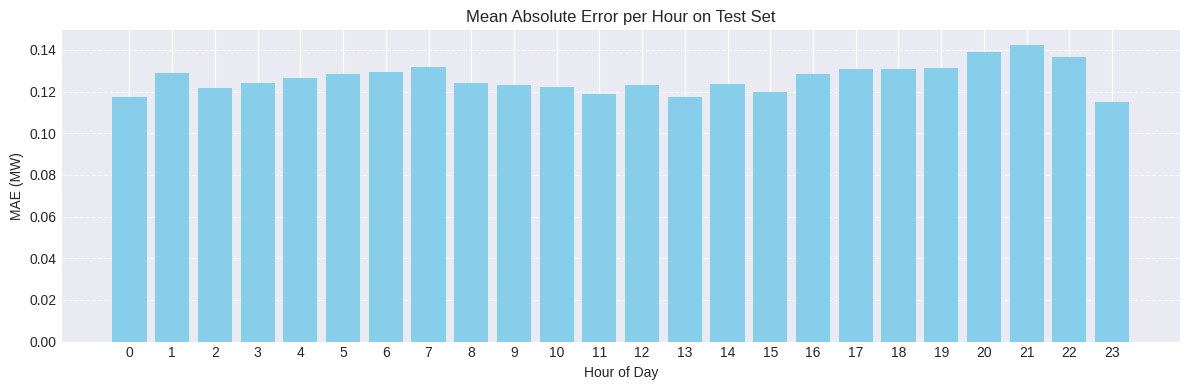

In [23]:
# ####################################
# Cell 8: Model Evaluation (No changes needed)
# ####################################
print("\n--- Evaluating the Trained Model ---")
if ml_model is not None and X_test_scaled is not None and y_test is not None:
    y_pred = np.maximum(0, ml_model.predict(X_test_scaled))
    mae_overall = mean_absolute_error(y_test, y_pred)
    r2_overall = r2_score(y_test, y_pred)
    print(f"Model Evaluation on Test Set:")
    print(f"  Overall MAE : {mae_overall:.4f} MW")
    print(f"  Overall R2  : {r2_overall:.4f}")
    # (Keep per-hour plots from previous cell if desired, or remove for brevity)
    mae_per_hour = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    hours = np.arange(24)
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.bar(hours, mae_per_hour, color='skyblue')
    ax.set_ylabel('MAE (MW)'); ax.set_xlabel('Hour of Day')
    ax.set_title('Mean Absolute Error per Hour on Test Set'); ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(hours); plt.tight_layout(); plt.show()
else:
    print("Skipping model evaluation.")

In [24]:
# ####################################
# Cell 9: Helper Functions for Interactive Input
# ####################################
print("\n--- Defining Input Helper Functions ---")

def get_validated_input(prompt, input_type=float, default=None, min_val=None, max_val=None):
    """Gets user input, validates type, range, and handles defaults."""
    while True:
        try:
            user_input = input(prompt).strip()
            if not user_input and default is not None:
                print(f"  -> Using default: {default}")
                return default
            elif not user_input and default is None:
                 print("  -> Input required, cannot be empty.")
                 continue # Re-prompt if required and empty

            value = input_type(user_input)

            if min_val is not None and value < min_val:
                print(f"  -> Error: Value must be at least {min_val}.")
            elif max_val is not None and value > max_val:
                print(f"  -> Error: Value must be no more than {max_val}.")
            else:
                return value # Valid input
        except ValueError:
            print(f"  -> Error: Invalid input. Please enter a valid {input_type.__name__}.")
        except Exception as e:
             print(f"  -> An unexpected error occurred: {e}")

def get_choice_input(prompt, options_map, default_key=None):
    """Gets user input corresponding to a key in a dictionary map."""
    print(prompt)
    for key, desc in options_map.items():
        print(f"  {key}: {desc}")
    prompt_text = f"Enter choice ({'/'.join(map(str, options_map.keys()))}) "
    if default_key is not None:
        prompt_text += f"[default: {default_key} ({options_map.get(default_key, 'N/A')})]: "
    else:
         prompt_text += ": "

    while True:
        try:
            user_input = input(prompt_text).strip()
            if not user_input and default_key is not None:
                print(f"  -> Using default: {default_key} ({options_map.get(default_key, 'N/A')})")
                return default_key
            elif not user_input and default_key is None:
                 print("  -> Input required, cannot be empty.")
                 continue

            choice_key = int(user_input) # Assume keys are integers for choices
            if choice_key in options_map:
                return choice_key
            else:
                print(f"  -> Error: Invalid choice. Please enter one of {list(options_map.keys())}.")
        except ValueError:
            print("  -> Error: Please enter a valid number corresponding to your choice.")
        except Exception as e:
             print(f"  -> An unexpected error occurred: {e}")


def get_list_input(prompt, default_all=True, data_type=int):
    """Gets comma-separated list input, handles 'all' or empty default."""
    while True:
        try:
            user_input = input(prompt).strip().lower()
            if not user_input and default_all:
                 print("  -> Using default: all")
                 return 'all'
            elif user_input == 'all':
                 return 'all'
            elif not user_input and not default_all:
                 print("  -> Input required, cannot be empty.")
                 continue

            # Try to split and convert
            items = [data_type(item.strip()) for item in user_input.split(',')]
            if not items: # Handle case where user enters only commas or whitespace
                 print("  -> Error: No valid items entered.")
                 continue
            # Optional: Add range checks for items if needed (e.g., buses 1-33)
            # Example: if any(item < 1 or item > 33 for item in items): print("Error: Bus numbers must be between 1 and 33.") continue
            return items # Return list of items
        except ValueError:
            print(f"  -> Error: Invalid input. Ensure all items are valid {data_type.__name__} separated by commas (e.g., 1,5,10).")
        except Exception as e:
            print(f"  -> An unexpected error occurred: {e}")


print("Input helper functions defined.")


--- Defining Input Helper Functions ---
Input helper functions defined.


In [25]:
# ####################################
# Cell 10: Interactive Simulation UI (Compact 2-Page Layout)
# ####################################
print("\n--- Setting up Compact Interactive Simulation UI ---")

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import traceback
import math

# Check prerequisites first
if 'base_ev_data' not in globals() or base_ev_data is None:
    print("\nERROR: Base EV data not loaded. Cannot run simulations.")
elif 'ml_model' not in globals() or ml_model is None or 'scaler' not in globals() or scaler is None:
    print("\nERROR: ML model or scaler not available. Cannot run ML predictions.")
else:
    print("Prerequisites met. Defining UI components...")

    # --- Define Widgets ---
    style = {'description_width': 'initial'}
    # Use smaller default widths/heights in layouts where possible
    layout_slider = widgets.Layout(width='90%', margin='2px 0')
    layout_text = widgets.Layout(width='90%', margin='2px 0')
    layout_button = widgets.Layout(width='auto', margin='2px 0')
    layout_box = widgets.Layout(padding='5px', margin='2px', width='98%') # General box layout

    # == Left Input Column Widgets ==
    w_fleet_title = widgets.HTML("<b>FLEET CONFIGURATION</b>", layout=widgets.Layout(margin='0 0 5px 0'))
    w_ev_participation = widgets.IntSlider(description='EV Participation (%):', min=0, max=100, step=1, value=100, style=style, layout=layout_slider)
    w_network_buses = widgets.Text(description='Network Buses (e.g., 1,5,10 or all):', value='all', style=style, layout=layout_text)
    w_ev_types = widgets.Text(description='EV Types (e.g., 1,2 or all):', value='all', style=style, layout=layout_text)

    w_overview_title = widgets.HTML("<b>SELECTED FLEET OVERVIEW</b>", layout=widgets.Layout(margin='8px 0 2px 0'))
    available_buses = sorted([int(b) for b in base_ev_data['Bus'].unique() if not math.isnan(b)]) if 'Bus' in base_ev_data.columns else ['all']
    available_types = sorted([int(t) for t in base_ev_data['VehicleType'].unique() if not math.isnan(t)]) if 'VehicleType' in base_ev_data.columns else [1, 2, 3]
    avg_cap_init = base_ev_data['CapacityMWh'].mean() * 1000 if 'CapacityMWh' in base_ev_data.columns else 0
    avg_rate_init = base_ev_data['MaxChargeRateMW'].mean() * 1000 if 'MaxChargeRateMW' in base_ev_data.columns else 0
    type_dist_init = base_ev_data['VehicleType'].value_counts().sort_index().to_dict() if 'VehicleType' in base_ev_data.columns else {}
    type_dist_str_init = ', '.join([f"T{int(k)}: {v}" for k, v in type_dist_init.items() if not math.isnan(k)])

    w_fleet_overview = widgets.HTML(
        value=f"Avg. Capacity: <b>{avg_cap_init:.1f} kWh</b><br>"
              f"Avg. Max Rate: <b>{avg_rate_init:.1f} kW</b><br>"
              f"Type Dist.: <b>{type_dist_str_init if type_dist_str_init else 'N/A'}</b>",
        layout=widgets.Layout(margin='0 0 5px 0')
    )
    w_fleet_capacity_dist_title = widgets.HTML("<b>Selected Fleet Capacity Distribution</b>", layout=widgets.Layout(margin='0 0 2px 0'))
    w_fleet_capacity_dist_output = widgets.Output(layout=widgets.Layout(margin='0 0 5px 0')) # Add margin to output
    with w_fleet_capacity_dist_output: # Initial plot (light bg)
        if 'CapacityMWh' in base_ev_data.columns and not base_ev_data['CapacityMWh'].empty:
            plt.style.use('default')
            fig, ax = plt.subplots(figsize=(4.5, 1.5)) # Further reduced height
            capacities_kwh = base_ev_data['CapacityMWh'] * 1000
            ax.hist(capacities_kwh.dropna(), bins=10, color='purple', range=(0, max(10, capacities_kwh.quantile(0.99)) if not capacities_kwh.empty else 100))
            ax.set_xlabel('Capacity (kWh)', fontsize=8)
            ax.set_ylabel('Count', fontsize=8)
            ax.tick_params(axis='both', which='major', labelsize=7)
            plt.grid(True, linestyle=':', alpha=0.4)
            plt.tight_layout(pad=0.1)
            plt.show()
        else: print("Capacity data not available.")

    w_timing_title = widgets.HTML("<b>GLOBAL TIMING ADJUSTMENTS</b>", layout=widgets.Layout(margin='8px 0 2px 0'))
    w_schedule_shift = widgets.IntSlider(description='Connection Schedule Shift (Hours):', min=-6, max=6, step=1, value=0, style=style, layout=layout_slider)
    w_soc_adjustment = widgets.IntSlider(description='Initial SOC Additive Adj. (%):', min=-20, max=20, step=1, value=0, style=style, layout=layout_slider)

    # Assemble Left Input Column
    left_input_column = widgets.VBox([
        w_fleet_title, w_ev_participation, w_network_buses, w_ev_types,
        w_overview_title, w_fleet_overview, w_fleet_capacity_dist_title, w_fleet_capacity_dist_output,
        w_timing_title, w_schedule_shift, w_soc_adjustment
    ], layout=widgets.Layout(width='49%')) # Use slightly less than 50% for gap

    # == Right Input Column Widgets ==
    w_strategy_title = widgets.HTML("<b>CHARGING STRATEGY & LOGIC</b>", layout=widgets.Layout(margin='0 0 5px 0'))
    w_charging_logic = widgets.RadioButtons(options={'Immediate Max Charging': 'immediate', 'Delayed Start Charging': 'delayed', 'Simple Off-Peak Logic': 'offpeak', 'Target SOC Charging': 'soc_target'}, value='immediate', description='Primary Charging Logic:', style=style, layout=layout_button)
    w_charge_delay = widgets.IntSlider(description='Charge Delay (Hours):', min=0, max=12, step=1, value=1, style=style, layout=widgets.Layout(display='none', width='90%', margin='2px 0'))
    w_peak_start = widgets.IntSlider(description='Peak Start Hour:', min=0, max=23, step=1, value=17, style=style, layout=widgets.Layout(display='none', width='90%', margin='2px 0'))
    w_peak_end = widgets.IntSlider(description='Peak End Hour:', min=0, max=23, step=1, value=20, style=style, layout=widgets.Layout(display='none', width='90%', margin='2px 0'))
    w_peak_reduction = widgets.IntSlider(description='Peak Reduction (%):', min=0, max=100, step=1, value=50, style=style, layout=widgets.Layout(display='none', width='90%', margin='2px 0'))
    w_soc_target = widgets.IntSlider(description='Target SOC (%):', min=50, max=100, step=1, value=80, style=style, layout=widgets.Layout(display='none', width='90%', margin='2px 0'))
    w_conditional_box = widgets.VBox([w_charge_delay, w_peak_start, w_peak_end, w_peak_reduction, w_soc_target], layout=widgets.Layout(margin='5px 0'))

    w_power_title = widgets.HTML("<b>POWER & EFFICIENCY PARAMETERS</b>", layout=widgets.Layout(margin='8px 0 2px 0'))
    w_global_charge_limit = widgets.IntText(description='Global Max Charging Rate Limit (kW):', value=22, style=style, layout=layout_text)
    w_charging_efficiency = widgets.IntSlider(description='Assumed Charging Efficiency (%):', min=80, max=100, step=1, value=90, style=style, layout=layout_slider)
    w_enable_v2g = widgets.Checkbox(description='Enable V2G Discharge', value=False, indent=False, style=style, layout=layout_button)
    w_v2g_threshold = widgets.FloatText(description='V2G Discharge Price Threshold:', value=0.50, style=style, layout=layout_text, disabled=True)

    w_variability_title = widgets.HTML("<b>SIMULATION VARIABILITY</b>", layout=widgets.Layout(margin='8px 0 2px 0'))
    w_start_randomness = widgets.IntSlider(description='Charging Start Time Randomness (+/- Minutes):', min=0, max=60, step=5, value=5, style=style, layout=layout_slider)

    # Assemble Right Input Column
    right_input_column = widgets.VBox([
        w_strategy_title, w_charging_logic, w_conditional_box,
        w_power_title, w_global_charge_limit, w_charging_efficiency, w_enable_v2g, w_v2g_threshold,
        w_variability_title, w_start_randomness
    ], layout=widgets.Layout(width='49%')) # Use slightly less than 50% for gap

    # == Output Section Widgets ==
    w_results_title = widgets.HTML("<h4>SIMULATION RESULTS DASHBOARD</h4>", layout=widgets.Layout(margin='0 0 5px 0'))

    # Metrics Display Widgets (Individual HTML boxes) - Reduced padding/margin
    metric_style = "<div style='border: 1px solid #CCC; padding: 4px; margin: 2px; text-align: center; min-width: 100px; flex-grow: 1;'>" # Reduced padding/margin
    metric_label_style = "font-size: 0.75em;" # Slightly smaller
    metric_value_style = "font-size: 1.0em; font-weight: bold;" # Slightly smaller
    metric_unit_style = "font-size: 0.8em;"
    metric_source_style = "font-size: 0.65em; color: grey;" # Smaller

    w_ml_peak_val = widgets.HTML(value=f"{metric_style}<span style='{metric_label_style}'>ML PEAK LOAD</span><br><span style='{metric_value_style}' id='ml-peak'>-.--</span> <span style='{metric_unit_style}'>MW</span><br><span style='{metric_source_style}'>(ML Model)</span></div>")
    w_sim_peak_val = widgets.HTML(value=f"{metric_style}<span style='{metric_label_style}'>SIM PEAK LOAD</span><br><span style='{metric_value_style}' id='sim-peak'>-.--</span> <span style='{metric_unit_style}'>MW</span><br><span style='{metric_source_style}'>(Detailed Sim)</span></div>")
    w_ml_energy_val = widgets.HTML(value=f"{metric_style}<span style='{metric_label_style}'>ML TOTAL ENERGY</span><br><span style='{metric_value_style}' id='ml-energy'>-.--</span> <span style='{metric_unit_style}'>MWh</span><br><span style='{metric_source_style}'>(ML Model)</span></div>")
    w_sim_energy_val = widgets.HTML(value=f"{metric_style}<span style='{metric_label_style}'>SIM TOTAL ENERGY</span><br><span style='{metric_value_style}' id='sim-energy'>-.--</span> <span style='{metric_unit_style}'>MWh</span><br><span style='{metric_source_style}'>(Detailed Sim)</span></div>")
    w_ml_lf_val = widgets.HTML(value=f"{metric_style}<span style='{metric_label_style}'>ML LOAD FACTOR</span><br><span style='{metric_value_style}' id='ml-lf'>-.--</span> <span style='{metric_unit_style}'>%</span><br><span style='{metric_source_style}'>(ML Model)</span></div>")
    w_ml_peak_time_val = widgets.HTML(value=f"{metric_style}<span style='{metric_label_style}'>ML TIME OF PEAK</span><br><span style='{metric_value_style}' id='ml-peak-time'>--:--</span><br><span style='{metric_source_style}'>(ML Model)</span></div>")
    w_sim_concurrent_val = widgets.HTML(value=f"{metric_style}<span style='{metric_label_style}'>MAX CONCURRENT</span><br><span style='{metric_value_style}' id='sim-concurrent'>----</span> <span style='{metric_unit_style}'>EVs</span><br><span style='{metric_source_style}'>(Detailed Sim)</span></div>")
    w_sim_soc_val = widgets.HTML(value=f"{metric_style}<span style='{metric_label_style}'>AVG FINAL SOC</span><br><span style='{metric_value_style}' id='sim-soc'>-.--</span> <span style='{metric_unit_style}'>%</span><br><span style='{metric_source_style}'>(Detailed Sim)</span></div>")

    w_metrics_row = widgets.HBox([w_ml_peak_val, w_sim_peak_val, w_ml_energy_val, w_sim_energy_val, w_ml_lf_val, w_ml_peak_time_val, w_sim_concurrent_val, w_sim_soc_val],
                               layout=widgets.Layout(flex_flow='row wrap', justify_content='flex-start', margin='0 0 5px 0')) # flex-start

    # Plot Widgets
    w_profile_title = widgets.HTML("<b>ML Predicted Aggregated Load Profile</b>", layout=widgets.Layout(margin='5px 0 2px 0'))
    w_profile_output = widgets.Output(layout=widgets.Layout(margin='0 0 5px 0'))
    w_concurrent_title = widgets.HTML("<b>CONCURRENT CHARGING ACTIVITY</b>", layout=widgets.Layout(margin='0 0 2px 0'))
    w_concurrent_output = widgets.Output()
    w_soc_dist_title = widgets.HTML("<b>FINAL STATE OF CHARGE (SOC)</b>", layout=widgets.Layout(margin='0 0 2px 0'))
    w_soc_dist_output = widgets.Output()
    w_ldc_title = widgets.HTML("<b>LOAD DURATION CURVE (ML)</b>", layout=widgets.Layout(margin='0 0 2px 0'))
    w_ldc_output = widgets.Output()
    w_bus_peaks_title = widgets.HTML("<b>TOP 5 BUS PEAK LOADS (SIM)</b>", layout=widgets.Layout(margin='5px 0 2px 0'))
    w_bus_peaks_output = widgets.Output(layout=widgets.Layout(margin='0 0 5px 0'))

    # HBox for the three plots - use % widths that add up to < 100 for small gaps
    plot_box_layout = widgets.Layout(width='32%', padding='2px') # Layout for individual plot VBoxes
    w_three_plots_row = widgets.HBox([
        widgets.VBox([w_concurrent_title, w_concurrent_output], layout=plot_box_layout),
        widgets.VBox([w_soc_dist_title, w_soc_dist_output], layout=plot_box_layout),
        widgets.VBox([w_ldc_title, w_ldc_output], layout=plot_box_layout)
    ], layout=widgets.Layout(justify_content='flex-start', margin='5px 0')) # flex-start

    # Interpretation Widgets
    w_interp_title = widgets.HTML("<b>INTERPRETATION</b>", layout=widgets.Layout(margin='5px 0 2px 0'))
    w_interp_output = widgets.HTML(value="<i>Run simulation to generate interpretation.</i>", layout=widgets.Layout(width='98%', padding='5px'))

    # Assemble Output Section (VBox)
    output_section = widgets.VBox([
        w_results_title, w_metrics_row,
        w_profile_title, w_profile_output,
        w_three_plots_row,
        w_bus_peaks_title, w_bus_peaks_output,
        w_interp_title, w_interp_output
    ], layout=widgets.Layout(padding='10px', margin='5px')) # Reduced padding/margin, removed border

    # --- Run Button & Status ---
    w_run_button = widgets.Button(description="Run Simulation", button_style='info', icon='play', layout=layout_button)
    w_status_label = widgets.Label(value="") # To show status

    # --- Main Layout (VBox) ---
    main_layout = widgets.VBox([
        widgets.HBox([left_input_column, right_input_column], layout=widgets.Layout(justify_content='flex-start')), # flex-start
        widgets.HBox([w_run_button, w_status_label], layout=widgets.Layout(justify_content='center', padding='5px')), # Reduced padding
        output_section
    ])

    # --- Interpretation Function (Python version - unchanged) ---
    def format_py(val, dec=1):
        if val is None: return 'N/A'
        try: num = float(val); return f"{num:.{dec}f}" if not math.isnan(num) else 'N/A'
        except (ValueError, TypeError): return 'N/A'

    def generate_interpretation_text_py(params, results):
        html = ''
        num_evs = results.get('sim_numEVs', 'N/A')
        # --- Para 1: Basic Summary ---
        html += f"<p style='margin: 2px 0;'>Simulating <b>{params.get('evPercentage', 'N/A'):.0f}%</b> ({num_evs}) of EVs" # Reduced margin
        buses_param = params.get('selectedBuses', 'N/A')
        if buses_param == 'all': html += " from <b>all network buses</b>"
        elif isinstance(buses_param, list) and len(buses_param) > 0: html += f" from <b>{len(buses_param)} selected buses</b>"
        else: html += " (bus selection unclear)"
        types_param = params.get('selectedEvTypes', 'N/A')
        if isinstance(types_param, list):
            if len(types_param) == len(available_types): html += ". "
            elif len(types_param) > 0: html += f" including types <b>{', '.join(map(str, types_param))}</b>. "
            else: html += " with <b>no EV types selected</b>. "
        else: html += " (EV type selection unclear). "
        html += f"Initial SOC adjusted by <b>{params.get('socAdjustment', 0):.0f}%</b>, connection times shifted by <b>{params.get('scheduleShift', 0):.0f} hours</b>.</p>"
        # --- Para 2: Charging Logic ---
        logic = params.get('chargingLogic', 'N/A')
        logic_display = logic.replace('_', ' ').title()
        html += f"<p style='margin: 2px 0;'>The <b>{logic_display}</b> charging logic was used. " # Reduced margin
        if logic == 'immediate': html += "This typically results in the highest immediate demand. "
        elif logic == 'delayed': html += f"EVs waited <b>{params.get('chargeDelay', 0)} hours</b> after connecting before charging. "
        elif logic == 'offpeak': html += f"Charging rate reduced by <b>{params.get('peakReduction', 0)}%</b> during peak hours (<b>{params.get('peakStart', 'N/A')}:00-{params.get('peakEnd', 'N/A')}:00</b>). "
        elif logic == 'soc_target': html += f"EVs stopped charging upon reaching <b>{params.get('socTarget', 100)}%</b> SOC. "
        else: html += "The selected charging logic was unclear. "
        html += f"Global charge rate limit: <b>{params.get('globalChargeLimit', 'N/A'):.1f} kW</b>/EV.</p>"
        # --- Para 3: Key Results ---
        ml_peak_valid = results.get('ml_peakLoad') is not None; sim_peak_valid = results.get('sim_peakLoad') is not None
        ml_energy_valid = results.get('ml_totalEnergy') is not None; sim_energy_valid = results.get('sim_totalEnergy') is not None
        if ml_peak_valid and sim_peak_valid and ml_energy_valid and sim_energy_valid:
             ml_peak_time_str = f"{results.get('ml_peakTime', '--:--')}"
             html += f"<p style='margin: 2px 0;'>ML predicted peak: <b>{format_py(results.get('ml_peakLoad'))} MW</b> (at {ml_peak_time_str}). Sim calculated peak: <b>{format_py(results.get('sim_peakLoad'))} MW</b>. " # Reduced margin
             html += f"Total energy: <b>{format_py(results.get('ml_totalEnergy'))} MWh</b> (ML) vs <b>{format_py(results.get('sim_totalEnergy'))} MWh</b> (Sim).</p>"
        else: html += "<p style='margin: 2px 0;'>Key results comparison incomplete.</p>"
        # --- Para 4: Detailed Sim Insights ---
        sim_concurrent_list = results.get('sim_concurrentEVs'); sim_concurrent_valid = isinstance(sim_concurrent_list, list) and len(sim_concurrent_list) > 0
        sim_avg_soc_val = results.get('sim_avgFinalSoc'); sim_avg_soc_valid = sim_avg_soc_val is not None
        if sim_concurrent_valid and sim_avg_soc_valid:
             max_concurrent = max(sim_concurrent_list) if sim_concurrent_list else 0; avg_soc = sim_avg_soc_val
             html += f"<p style='margin: 2px 0;'>Detailed sim insights: Max concurrency was <b>{max_concurrent} EVs</b>. Average final SOC was <b>{format_py(avg_soc)}%</b>. " # Reduced margin
             if avg_soc < 70 and logic != 'soc_target': html += "Low avg SOC might suggest limited charging time or restrictive parameters."
             elif avg_soc > 95: html += "Indicates most EVs reached high state of charge."
             else: html += "Reflects overall energy replenishment."
             html += "</p>"
        elif results.get('error_sim'): html += f"<p style='margin: 2px 0;'>Detailed simulation error: {results['error_sim']}.</p>"
        elif num_evs != 'N/A': html += "<p style='margin: 2px 0;'>Detailed sim ran, but Concurrency/Avg SOC results missing.</p>"
        else: html += "<p style='margin: 2px 0;'>Detailed simulation insights unavailable.</p>"
        # --- Para 5: Concluding Note ---
        html += "<p style='margin: 2px 0;'><i><small>Note: ML predictions are rapid estimates. Detailed simulations offer granular insights but are slower. Differences are expected.</small></i></p>" # Reduced margin
        return html

    # --- Widget Interaction Logic (unchanged) ---
    def on_logic_change(change):
        logic = change['new']
        w_charge_delay.layout.display = 'flex' if logic == 'delayed' else 'none'
        w_peak_start.layout.display = 'flex' if logic == 'offpeak' else 'none'
        w_peak_end.layout.display = 'flex' if logic == 'offpeak' else 'none'
        w_peak_reduction.layout.display = 'flex' if logic == 'offpeak' else 'none'
        w_soc_target.layout.display = 'flex' if logic == 'soc_target' else 'none'
    w_charging_logic.observe(on_logic_change, names='value')

    def on_v2g_enable_change(change):
        w_v2g_threshold.disabled = not change['new']
    w_enable_v2g.observe(on_v2g_enable_change, names='value')

    # --- Button Click Handler (Plotting part adjusted for light bg) ---
    def run_simulation_callback(button):
        w_status_label.value = " Processing..."
        w_run_button.disabled = True

        # Clear outputs and reset metrics (same as before)
        outputs_to_clear = [w_profile_output, w_concurrent_output, w_soc_dist_output, w_ldc_output, w_bus_peaks_output]
        for out in outputs_to_clear: out.clear_output(wait=True)
        w_interp_output.value = "<i>Running simulation...</i>"
        metric_widgets = { 'ml-peak': w_ml_peak_val, 'sim-peak': w_sim_peak_val, 'ml-energy': w_ml_energy_val, 'sim-energy': w_sim_energy_val, 'ml-lf': w_ml_lf_val, 'ml-peak-time': w_ml_peak_time_val, 'sim-concurrent': w_sim_concurrent_val, 'sim-soc': w_sim_soc_val }
        for key, widget in metric_widgets.items():
            start_tag = f"<span style='{metric_value_style}' id='{key}'>"
            end_tag = "</span>"
            start_index = widget.value.find(start_tag); end_index = widget.value.find(end_tag, start_index + len(start_tag) if start_index!=-1 else -1)
            if start_index != -1 and end_index != -1: widget.value = widget.value[:start_index + len(start_tag)] + "-.--" + widget.value[end_index:]

        # 1. Gather parameters (Same as before)
        params = {}; results_collector = {}; error_during_run = None
        try:
            params['evPercentage'] = float(w_ev_participation.value)
            buses_in = w_network_buses.value.strip().lower(); params['selectedBuses'] = 'all' if buses_in == 'all' else [int(b.strip()) for b in buses_in.split(',') if b.strip()]
            types_in = w_ev_types.value.strip().lower(); params['selectedEvTypes'] = list(available_types) if types_in == 'all' else [int(t.strip()) for t in types_in.split(',') if t.strip()]
            params['chargingLogic'] = w_charging_logic.value; params['chargeDelay'] = w_charge_delay.value
            params['peakStart'] = w_peak_start.value; params['peakEnd'] = w_peak_end.value; params['peakReduction'] = w_peak_reduction.value
            params['socTarget'] = w_soc_target.value; params['globalChargeLimit'] = float(w_global_charge_limit.value)
            params['scheduleShift'] = w_schedule_shift.value; params['socAdjustment'] = w_soc_adjustment.value
            params['chargingEfficiency'] = w_charging_efficiency.value; params['enableV2G'] = w_enable_v2g.value
            params['v2gThreshold'] = w_v2g_threshold.value if w_enable_v2g.value else 0; params['startTimeRandomness'] = w_start_randomness.value
        except Exception as e: w_status_label.value = f" Error reading inputs: {e}"; w_run_button.disabled = False; error_during_run = f"Input Error: {e}"; w_interp_output.value = generate_interpretation_text_py(params, {'error_sim': error_during_run}); return

        # 2. Run ML Prediction (Same as before)
        pred_start_time = time.time()
        try:
            scenario_input_scaled = prepare_ml_input(params, FEATURE_COLUMNS, LOGIC_MAP_REVERSE, scaler)
            predicted_load_scenario = np.maximum(0, ml_model.predict(scenario_input_scaled)[0])
            results_collector['ml_peakLoad'] = np.max(predicted_load_scenario) if predicted_load_scenario is not None else None
            results_collector['ml_totalEnergy'] = np.sum(predicted_load_scenario) if predicted_load_scenario is not None else None
            ml_avg = results_collector['ml_totalEnergy'] / 24 if results_collector['ml_totalEnergy'] is not None else 0
            results_collector['ml_loadFactor'] = (ml_avg / results_collector['ml_peakLoad'] * 100) if results_collector.get('ml_peakLoad', 0) > 1e-6 else 0
            ml_peak_hour = np.argmax(predicted_load_scenario) if predicted_load_scenario is not None else -1
            results_collector['ml_peakTime'] = f"{ml_peak_hour:02d}:00" if ml_peak_hour != -1 else "--:--"
        except Exception as e: results_collector['error_ml'] = str(e); traceback.print_exc()
        pred_time = time.time() - pred_start_time

        # 3. Run Detailed Simulation (Same as before)
        sim_start_time = time.time()
        try:
            sim_results_scenario = run_detailed_simulation(params, base_ev_data)
            results_collector['sim_hourlyLoad'] = sim_results_scenario.get('hourlyLoad'); results_collector['sim_peakLoad'] = sim_results_scenario.get('peakLoad')
            results_collector['sim_totalEnergy'] = sim_results_scenario.get('totalEnergy'); results_collector['sim_avgFinalSoc'] = sim_results_scenario.get('avgFinalSoc')
            results_collector['sim_concurrentEVs'] = sim_results_scenario.get('concurrentEVs'); results_collector['sim_numEVs'] = sim_results_scenario.get('numEVsSimulated', 'N/A')
            results_collector['sim_finalSOCs'] = sim_results_scenario.get('finalSOCs', []); bus_loads_sim = sim_results_scenario.get('busLoads', {})
            results_collector['sim_topBusPeaks'] = sorted([(bus, max(load)*1000) for bus, load in bus_loads_sim.items() if load], key=lambda item: item[1], reverse=True)[:5] if bus_loads_sim else []
        except Exception as e: results_collector['error_sim'] = str(e); traceback.print_exc()
        sim_time = time.time() - sim_start_time

        # 4. Update Metric Widgets (Same as before)
        def update_metric_html(widget, element_id, value_str):
             start_tag = f"<span style='{metric_value_style}' id='{element_id}'>"
             end_tag = "</span>"; start_index = widget.value.find(start_tag)
             if start_index != -1:
                 end_index = widget.value.find(end_tag, start_index + len(start_tag))
                 if end_index != -1: widget.value = widget.value[:start_index + len(start_tag)] + value_str + widget.value[end_index:]
        update_metric_html(w_ml_peak_val, 'ml-peak', format_py(results_collector.get('ml_peakLoad'), 2))
        update_metric_html(w_sim_peak_val, 'sim-peak', format_py(results_collector.get('sim_peakLoad'), 2))
        update_metric_html(w_ml_energy_val, 'ml-energy', format_py(results_collector.get('ml_totalEnergy'), 2))
        update_metric_html(w_sim_energy_val, 'sim-energy', format_py(results_collector.get('sim_totalEnergy'), 2))
        update_metric_html(w_ml_lf_val, 'ml-lf', format_py(results_collector.get('ml_loadFactor'), 1))
        update_metric_html(w_ml_peak_time_val, 'ml-peak-time', results_collector.get('ml_peakTime', '--:--'))
        max_c = max(results_collector.get('sim_concurrentEVs', [0])) if results_collector.get('sim_concurrentEVs') else 0
        update_metric_html(w_sim_concurrent_val, 'sim-concurrent', str(max_c))
        update_metric_html(w_sim_soc_val, 'sim-soc', format_py(results_collector.get('sim_avgFinalSoc'), 1))

        # 5. Generate Plots (Using default light style)
        hours = np.arange(24)
        plt.style.use('default') # Set light style

        # --- Profile Plot ---
        with w_profile_output:
            fig_prof, ax_prof = plt.subplots(figsize=(9, 3)) # Adjusted size
            if predicted_load_scenario is not None:
                ax_prof.plot(hours, predicted_load_scenario, label='ML Pred.', color='deepskyblue', marker='.', lw=1.5)
            ax_prof.set_xlabel('Hour', fontsize=9); ax_prof.set_ylabel('Power (MW)', fontsize=9)
            ax_prof.tick_params(axis='both', which='major', labelsize=8); ax_prof.legend(fontsize=8)
            ax_prof.grid(True, linestyle=':', alpha=0.6); ax_prof.set_ylim(bottom=0)
            ax_prof.set_xticks(hours[::2]); plt.tight_layout(pad=0.1)
            plt.show()

        # --- Concurrent EVs ---
        with w_concurrent_output:
            sim_concurrent = results_collector.get('sim_concurrentEVs')
            if sim_concurrent:
                fig_conc, ax_conc = plt.subplots(figsize=(4, 2.5)) # Smaller plots for row
                ax_conc.bar(hours, sim_concurrent, color='darkorange')
                ax_conc.set_title('Concurrent EVs (Sim)', fontsize=9)
                ax_conc.set_xlabel('Hour', fontsize=8); ax_conc.set_ylabel('Count', fontsize=8)
                ax_conc.tick_params(axis='both', which='major', labelsize=7)
                ax_conc.set_xticks(hours[::4]); ax_conc.grid(axis='y', linestyle='--', alpha=0.4)
                plt.tight_layout(pad=0.1); plt.show()
            else: print("Concurrent EV data unavailable.")

        # --- Final SOC ---
        with w_soc_dist_output:
            final_socs_list = results_collector.get('sim_finalSOCs')
            if final_socs_list:
                fig_soc, ax_soc = plt.subplots(figsize=(4, 2.5)) # Smaller plots for row
                ax_soc.hist([s for s in final_socs_list if s is not None and not math.isnan(s)],
                            bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color='limegreen', rwidth=0.8)
                ax_soc.set_title('Final SOC Dist. (Sim)', fontsize=9)
                ax_soc.set_xlabel('SOC (%)', fontsize=8); ax_soc.set_ylabel('Count', fontsize=8)
                ax_soc.tick_params(axis='both', which='major', labelsize=7)
                ax_soc.set_xticks(np.arange(0, 101, 20)); ax_soc.grid(axis='y', linestyle='--', alpha=0.4)
                plt.tight_layout(pad=0.1); plt.show()
            else: print("Final SOC data unavailable.")

        # --- Load Duration Curve ---
        with w_ldc_output:
            if predicted_load_scenario is not None:
                sorted_load = np.sort(predicted_load_scenario)[::-1]
                fig_ldc, ax_ldc = plt.subplots(figsize=(4, 2.5)) # Smaller plots for row
                ax_ldc.plot(np.arange(1, 25), sorted_load, color='red', lw=1.5)
                ax_ldc.set_title('Load Duration Curve (ML)', fontsize=9)
                ax_ldc.set_xlabel('Hours (Sorted)', fontsize=8); ax_ldc.set_ylabel('Power (MW)', fontsize=8)
                ax_ldc.tick_params(axis='both', which='major', labelsize=7)
                ax_ldc.set_xticks(np.arange(1, 25, 4)); ax_ldc.grid(True, linestyle=':', alpha=0.4)
                ax_ldc.set_ylim(bottom=0); plt.tight_layout(pad=0.1); plt.show()
            else: print("ML Load data needed for LDC.")

        # --- Top 5 Bus Peaks ---
        with w_bus_peaks_output:
            top_bus_peaks = results_collector.get('sim_topBusPeaks', [])
            if top_bus_peaks:
                bus_peak_df = pd.DataFrame(top_bus_peaks, columns=['Bus ID', 'Peak Load (kW)'])
                html_table = "<table border='1' style='width:60%; border-collapse: collapse; font-size: 0.8em; margin-top: 3px;'><tr><th>Bus ID</th><th>Peak Load (kW)</th></tr>" # Adjusted width/font/margin
                for _, row in bus_peak_df.iterrows(): html_table += f"<tr><td style='text-align:center;'>{int(row['Bus ID'])}</td><td style='text-align:right; padding-right: 5px;'>{row['Peak Load (kW)']:.2f}</td></tr>"
                html_table += "</table>"; display(widgets.HTML(html_table))
            else: display(widgets.HTML("<i style='font-size:0.8em'>Bus peak load data not available.</i>"))

        # 6. Generate Interpretation Text (uses updated function)
        w_interp_output.value = generate_interpretation_text_py(params, results_collector)

        # 7. Reset status and button
        status_msg = f"Finished in {pred_time:.2f}s (ML) + {sim_time:.2f}s (Sim)."; w_status_label.value = status_msg; w_run_button.disabled = False

    # --- Attach Callback and Display ---
    w_run_button.on_click(run_simulation_callback)
    print("UI Ready. Displaying layout...")
    display(main_layout)
    # Trigger initial display states
    on_logic_change({'new': w_charging_logic.value})
    on_v2g_enable_change({'new': w_enable_v2g.value})


# Handle prerequisite failure
if 'base_ev_data' not in globals() or base_ev_data is None or 'ml_model' not in globals() or ml_model is None or 'scaler' not in globals() or scaler is None:
     print("\nInteractive UI could not be displayed due to missing data or model.")


--- Setting up Compact Interactive Simulation UI ---
Prerequisites met. Defining UI components...
UI Ready. Displaying layout...
